## **EXP1 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP1 analysis and results. Files used were created in preprocessing/EXP1_pseudos notebook.*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file and can be run through paperpill using run_EXP1.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_5CTnoise"
files_path = "/../data/EXP1/"
cibersort_files = "/../data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
noise_type = "5CTnoise"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "random"
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
kerne_name = "env_ml"

In [3]:
# Parameters
res_name = "MCT_pbmc_EXP1"
pseudo_name = "MCT_pbmc_EXP1_noise"
files_path = "/data/EXP1/"
noise_type = "noise"
cibersort_files = "/data/EXP1/cibersort/CIBERSORTx_Job54_MCT_pbmc_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job54_MCT_pbmc_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
random_seed = 88
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"

Import the previously processed datasets. 

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [5]:
#and as anndata object
adata_path = os.path.join(path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
Counter(sn_adata.obs["cell_types"])

Counter({'FCGR3A Monocytes': 163,
         'B': 342,
         'CD4 T': 1131,
         'NK': 200,
         'CD8 T': 317,
         'CD14 Monocytes': 436})

In [7]:
#excluding all cell types except 5 of interest
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": #if pseudos have 5 cell types
    exclude = ['preadipocyte',
        'mesothelial cell',
        'pericyte cell',
        'fat cell',
        'endothelial cell',
        'endothelial cell of lymphatic vessel',
        'smooth muscle cell',
        'mast cell',
        'immature NK T cell',
        'stromal cell of endometrium',
        'neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1131, 'CD14 Monocytes': 436, 'B': 342, 'CD8 T': 317, 'NK': 200, 'FCGR3A Monocytes': 163})


Randomly selecting cells to delete:

In [8]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [], 1: [2], 2: [0, 2], 3: [0, 2, 4], 4: [0, 2, 3, 4]}

## Creating reference profiles and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [9]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

FCGR3A Monocytes       B   CD4 T      NK   CD8 T  \
AL627309.1                  0.0     0.0    18.0     0.0    34.0   
AP006222.2                  0.0     0.0     8.0     0.0    28.0   
RP11-206L10.2               0.0    62.0    10.0     0.0     0.0   
RP11-206L10.9               0.0     0.0     0.0    43.0     0.0   
LINC00115                  58.0    83.0    52.0    95.0    51.0   
...                         ...     ...     ...     ...     ...   
AC145212.1                  0.0    61.0    34.0   182.0    20.0   
AL592183.1               1312.0  1743.0  1384.0  1244.0  1390.0   
AL354822.1                  0.0    53.0    18.0   140.0     0.0   
PNRC2-1                   618.0   277.0   482.0   421.0   420.0   
SRSF10-1                  114.0   289.0   335.0   486.0   239.0   

               CD14 Monocytes  
AL627309.1              129.0  
AP006222.2               21.0  
RP11-206L10.2             0.0  
RP11-206L10.9            40.0  
LINC00115                98.0  
...                       ...  
AC145212.1              120.0  
AL592183.1              969.0  
AL354822.1               15.0  
PNRC2-1                 271.0  
SRSF10-1                  0.0  

[13714 rows x 6 columns]

In [10]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

FCGR3A Monocytes         B     CD4 T        NK     CD8 T  \
AL627309.1             0.000000  0.000000  0.004780  0.000000  0.009029   
AP006222.2             0.000000  0.000000  0.002124  0.000000  0.007435   
RP11-206L10.2          0.000000  0.016464  0.002655  0.000000  0.000000   
RP11-206L10.9          0.000000  0.000000  0.000000  0.011418  0.000000   
LINC00115              0.015402  0.022040  0.013808  0.025227  0.013543   
...                         ...       ...       ...       ...       ...   
AC145212.1             0.000000  0.016198  0.009029  0.048329  0.005311   
AL592183.1             0.348394  0.462844  0.367513  0.330337  0.369107   
AL354822.1             0.000000  0.014074  0.004780  0.037176  0.000000   
PNRC2-1                0.164106  0.073556  0.127992  0.111794  0.111529   
SRSF10-1               0.030272  0.076742  0.088957  0.129055  0.063465   

               CD14 Monocytes  
AL627309.1           0.034255  
AP006222.2           0.005576  
RP11-206L10.2        0.000000  
RP11-206L10.9        0.010622  
LINC00115            0.026023  
...                       ...  
AC145212.1           0.031865  
AL592183.1           0.257312  
AL354822.1           0.003983  
PNRC2-1              0.071962  
SRSF10-1             0.000000  

[13714 rows x 6 columns]

Importing Bulks:

In [11]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [12]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

900

In [13]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2


3
4


5
6


7


8


9


In [14]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_27190/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [15]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulkprop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df.columns = sn_adata.var_names
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9    LINC00115  \
0      214.822973  132.083945      57.714401      31.624914   422.808819   
1       28.714498   37.267942      58.929190       1.878046  1549.886953   
2       65.609550   15.496164      26.314640     108.908076  1888.541877   
3        1.114940   22.238098     135.430829       0.000000  2806.485803   
4       89.156544    1.971219      58.897615       2.101716  1753.191642   
...           ...         ...            ...            ...          ...   
1995   177.490282    4.303997       2.781992      19.541805  1125.195295   
1996    68.969136   45.520747     178.999392     158.209639  3084.817333   
1997   646.260475   42.203989      14.020709     159.147149  1957.410123   
1998  2576.302201   75.528248      10.338891     535.301479  3035.160306   
1999   580.759609   29.537938       0.000000      75.290649   275.285604   

              NOC2L      KLHL17     PLEKHN1  RP11-54O7.17          HES4  ...  \
0     327048.720044  260.017221  341.410913      7.776736  2.590987e+05  ...   
1     392730.130288  260.523688  423.258812      0.000000  1.425959e+05  ...   
2     338188.003452  325.124271  132.571200    122.378054  1.308546e+06  ...   
3     397897.258106  343.044211  120.654878      4.221186  9.156633e+04  ...   
4     248869.209294  265.066820   34.977706     46.729527  6.074020e+04  ...   
...             ...         ...         ...           ...           ...  ...   
1995  435272.585346   92.686449  207.854298    208.308269  6.773645e+05  ...   
1996  243893.704555  201.075963   57.088200     92.910489  1.036658e+06  ...   
1997  429046.312464  209.238609   22.699405    248.433974  4.796565e+05  ...   
1998  199614.109555   33.823317  447.186406    137.871574  1.553483e+05  ...   
1999  137996.248061  393.667921  300.152882     91.923851  1.253971e+05  ...   

           MT-ND4L        MT-ND4        MT-ND5         MT-ND6        MT-CYB  \
0     5.122289e+05  7.192365e+08  1.592149e+07  295773.513246  5.649523e+08   
1     8.328953e+05  5.848257e+08  1.476008e+07  295640.393761  5.244107e+08   
2     7.913187e+05  8.717069e+08  2.912016e+07  222460.571193  4.363676e+08   
3     1.119575e+06  7.475571e+08  1.552530e+07  279156.346935  7.558713e+08   
4     7.597062e+05  4.679715e+08  1.103888e+07  206426.376020  4.209204e+08   
...            ...           ...           ...            ...           ...   
1995  4.951740e+05  4.611115e+08  1.819307e+07  241613.450649  3.740864e+08   
1996  7.283581e+05  8.778014e+08  1.888478e+07  317162.244297  4.821112e+08   
1997  6.568146e+05  7.185064e+08  2.055100e+07  366004.132477  3.778577e+08   
1998  3.427243e+05  4.893228e+08  1.111291e+07  166667.390011  3.715245e+08   
1999  7.501276e+05  3.682438e+08  2.081151e+07  264335.536994  4.142017e+08   

       AC145212.1     AL592183.1   AL354822.1       PNRC2-1      SRSF10-1  
0     1142.245446  616700.293567    74.303674  44125.738273  12939.216404  
1     1069.843152  589011.065632   175.129141  47816.744471  16401.803442  
2     2976.166059  259468.436711   955.625696  55809.178619  13806.139241  
3     1810.344402  723631.988176  1476.189779  61296.180350  26482.212678  
4      468.945637  280491.267153   100.481576  21013.750330  10033.206692  
...           ...            ...          ...           ...           ...  
1995   935.624617  499799.062309   739.390895  44865.670265  11400.552670  
1996  1220.056474  453444.226870   469.297858  52493.302600  18581.663755  
1997  2620.926678  368717.595129   236.681356  82841.572323  14285.773312  
1998  2692.968033  280292.976248   111.715331  29357.014720   2086.899965  
1999   956.801255  396334.857589   136.768574  30749.552659   9169.624754  

[2000 rows x 13714 columns]

In [16]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9    LINC00115  \
1059   260.431052    0.000000     162.099397     157.453617  1326.489521   
929      3.109866    0.000000       2.476534      37.799057  2299.127185   
1506   804.473747   83.428134      11.934176     107.602483  1472.566205   
237     84.279083    3.816787      38.198635     110.663207  2224.164759   
1371   721.121388  115.475799       9.018028     180.944558  1316.427740   
...           ...         ...            ...            ...          ...   
1573  1045.847651   61.620100       0.832962      28.358600  2453.471170   
1132  1525.233589   48.435610       0.000000     255.966754  1364.590575   
1998  2576.302201   75.528248      10.338891     535.301479  3035.160306   
1988    46.493183   35.870142      19.825580      39.394850   857.047083   
1167    35.775961   27.060248       2.301430       2.624440  1192.226492   

              NOC2L      KLHL17     PLEKHN1  RP11-54O7.17          HES4  ...  \
1059  482118.516118  136.990628  139.706042    152.087456  1.518845e+06  ...   
929   603366.619629  296.871130  131.559777    168.258346  3.387044e+06  ...   
1506  284328.192180  243.452283   63.993455     50.839794  4.248142e+05  ...   
237   412519.941823  173.722653   42.942543     24.018486  8.501304e+05  ...   
1371  274587.461056   96.251304   64.293871     36.388834  3.554214e+05  ...   
...             ...         ...         ...           ...           ...  ...   
1573  303421.145483  177.961610  532.515653    152.259362  3.503265e+05  ...   
1132  227116.625726   95.722909  177.222611    157.445163  8.235163e+05  ...   
1998  199614.109555   33.823317  447.186406    137.871574  1.553483e+05  ...   
1988  303888.098961   62.700847   70.259436     69.349660  3.153106e+05  ...   
1167  174725.598714  172.327722  230.535066     59.502080  6.622479e+04  ...   

           MT-ND4L        MT-ND4        MT-ND5         MT-ND6        MT-CYB  \
1059  1.023321e+06  7.520249e+08  2.228342e+07  491758.898041  7.478720e+08   
929   7.600625e+05  8.950473e+08  3.570099e+07  406742.856609  1.071459e+09   
1506  7.593631e+05  6.533179e+08  2.233486e+07  170854.651438  6.376870e+08   
237   5.818218e+05  9.944316e+08  2.496339e+07  432730.445443  4.971186e+08   
1371  6.068205e+05  4.529403e+08  2.374803e+07  245871.593822  5.767590e+08   
...            ...           ...           ...            ...           ...   
1573  6.581732e+05  5.425523e+08  2.012272e+07  210736.725096  3.358847e+08   
1132  9.164849e+05  6.245086e+08  1.750305e+07  182304.914589  3.818343e+08   
1998  3.427243e+05  4.893228e+08  1.111291e+07  166667.390011  3.715245e+08   
1988  5.994289e+05  5.531125e+08  1.481962e+07  266252.835528  3.392621e+08   
1167  3.941568e+05  4.934694e+08  1.074542e+07  221103.010570  4.653698e+08   

       AC145212.1     AL592183.1   AL354822.1       PNRC2-1      SRSF10-1  
1059  4949.497019  627654.648610  1854.288611  31254.504699  20191.621233  
929   6540.623970  525701.031726  2653.410130  52449.977572  28673.357085  
1506  1665.363914  423100.326121   189.977575  48814.854631   6253.957382  
237   1329.852404  382639.908694   701.113133  62045.939096  19915.065471  
1371  2470.570012  334014.070710   400.533168  32925.311214   8725.198077  
...           ...            ...          ...           ...           ...  
1573  1717.815454  349545.006082   221.215597  31930.504671   6485.211843  
1132  1668.771196  417159.573256  1045.784721  26977.373999   7216.906167  
1998  2692.968033  280292.976248   111.715331  29357.014720   2086.899965  
1988   517.195115  467904.136308   135.237654  39407.859187  10690.733623  
1167   101.219568  333744.798536    45.271298  36202.871898   6551.453321  

[1000 rows x 13714 columns]

In [17]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  \
1059    0.061523    0.000000       0.110947       0.165610   0.206769   
929     0.000735    0.000000       0.001695       0.039757   0.390094   
1506    0.190046    0.155865       0.008168       0.113176   0.234302   
237     0.019910    0.007131       0.026145       0.116396   0.375965   
1371    0.170355    0.215738       0.006172       0.190318   0.204873   
...          ...         ...            ...            ...        ...   
1573    0.247068    0.115122       0.000570       0.029828   0.419185   
1132    0.360316    0.090490       0.000000       0.269226   0.213951   
1998    0.608618    0.141106       0.007076       0.563030   0.528823   
1988    0.010983    0.067015       0.013569       0.041436   0.118288   
1167    0.008452    0.050555       0.001575       0.002760   0.181463   

         NOC2L    KLHL17   PLEKHN1  RP11-54O7.17      HES4  ...   MT-ND4L  \
1059  0.493042  0.120674  0.100773      0.117587  0.415233  ...  0.585322   
929   0.652641  0.261511  0.094897      0.130090  0.926665  ...  0.380366   
1506  0.232691  0.214455  0.046160      0.039307  0.115734  ...  0.379822   
237   0.401430  0.153031  0.030976      0.018570  0.232167  ...  0.241600   
1371  0.219870  0.084787  0.046377      0.028134  0.096737  ...  0.261062   
...        ...       ...       ...           ...       ...  ...       ...   
1573  0.257823  0.156765  0.384117      0.117720  0.095343  ...  0.301042   
1132  0.157384  0.084321  0.127835      0.121730  0.224882  ...  0.502147   
1998  0.121182  0.029795  0.322567      0.106596  0.041966  ...  0.055455   
1988  0.258438  0.055233  0.050680      0.053618  0.085757  ...  0.255308   
1167  0.088422  0.151802  0.166291      0.046004  0.017568  ...  0.095497   

      MT-ND4  MT-ND5    MT-ND6  MT-CYB  AC145212.1  AL592183.1  AL354822.1  \
1059     0.0     0.0  0.439902     0.0    0.376928    0.411528    0.341863   
929      0.0     0.0  0.352887     0.0    0.498100    0.317996    0.489192   
1506     0.0     0.0  0.111450     0.0    0.126825    0.223871    0.035025   
237      0.0     0.0  0.379486     0.0    0.101275    0.186753    0.129260   
1371     0.0     0.0  0.188231     0.0    0.188146    0.142144    0.073844   
...      ...     ...       ...     ...         ...         ...         ...   
1573     0.0     0.0  0.152270     0.0    0.130820    0.156392    0.040784   
1132     0.0     0.0  0.123170     0.0    0.127085    0.218421    0.192804   
1998     0.0     0.0  0.107164     0.0    0.205082    0.092861    0.020596   
1988     0.0     0.0  0.209092     0.0    0.039387    0.264974    0.024933   
1167     0.0     0.0  0.162880     0.0    0.007708    0.141897    0.008346   

       PNRC2-1  SRSF10-1  
1059  0.145656  0.273878  
929   0.301541  0.392515  
1506  0.274806  0.078926  
237   0.372115  0.270009  
1371  0.157944  0.113492  
...        ...       ...  
1573  0.150628  0.082160  
1132  0.114199  0.092395  
1998  0.131700  0.020639  
1988  0.205621  0.140985  
1167  0.182049  0.083087  

[1000 rows x 13714 columns]

In [18]:
# read in cibersort genes 
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

1281

In [19]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

HES4      SDF4    UBE2J2      MIB2      NADK      GNB1    KCNAB2  \
1059  0.415233  0.388458  0.261202  0.231928  0.237344  0.236647  0.330620   
929   0.926665  0.245650  0.173945  0.131151  0.410848  0.394697  0.453379   
1506  0.115734  0.337568  0.279226  0.113351  0.090022  0.288573  0.211381   
237   0.232167  0.298396  0.372342  0.140529  0.117420  0.194389  0.387270   
1371  0.096737  0.216925  0.143694  0.105473  0.112575  0.128298  0.099875   
...        ...       ...       ...       ...       ...       ...       ...   
1573  0.095343  0.353483  0.163523  0.188674  0.171481  0.176143  0.215060   
1132  0.224882  0.140570  0.118198  0.065772  0.158906  0.272406  0.132812   
1998  0.041966  0.172229  0.183913  0.031783  0.090309  0.267088  0.207860   
1988  0.085757  0.301939  0.368915  0.339311  0.055017  0.074318  0.157865   
1167  0.017568  0.168065  0.168605  0.172578  0.038737  0.058133  0.079816   

      TNFRSF25     VAMP3      RBP7  ...    IFNAR2    IL10RB    IFNGR2  \
1059  0.043621  0.296749  0.180458  ...  0.386243  0.339151  0.711922   
929   0.183760  0.350404  0.104667  ...  0.436345  0.465671  1.000000   
1506  0.114305  0.173037  0.402734  ...  0.312787  0.192973  0.999351   
237   0.174103  0.224918  0.067290  ...  0.375823  0.194950  0.739554   
1371  0.032068  0.222469  0.204314  ...  0.133775  0.128624  0.520339   
...        ...       ...       ...  ...       ...       ...       ...   
1573  0.077088  0.231670  0.135009  ...  0.466393  0.145079  0.794480   
1132  0.032599  0.374193  0.465976  ...  0.246591  0.342262  0.959191   
1998  0.047966  0.196727  0.654131  ...  0.093238  0.188512  1.000000   
1988  0.134699  0.082202  0.021673  ...  0.293615  0.144609  0.116591   
1167  0.105848  0.031605  0.020914  ...  0.191648  0.052284  0.135098   

          CBR1      TTC3       MX2    NDUFV3      PDXK      PFKL  AL592183.1  
1059  0.254949  0.239182  0.270449  0.339997  0.184044  0.153030    0.411528  
929   0.298399  0.224114  0.566438  0.261325  0.199411  0.418413    0.317996  
1506  0.198422  0.105567  0.245549  0.300826  0.295849  0.101319    0.223871  
237   0.222603  0.191485  0.223589  0.187610  0.121732  0.140986    0.186753  
1371  0.164805  0.089992  0.125968  0.180035  0.151700  0.121891    0.142144  
...        ...       ...       ...       ...       ...       ...         ...  
1573  0.225803  0.073631  0.198766  0.318939  0.161896  0.112135    0.156392  
1132  0.340596  0.089756  0.312905  0.347690  0.263396  0.161093    0.218421  
1998  0.226728  0.033687  0.224960  0.380894  0.256183  0.124785    0.092861  
1988  0.069030  0.065383  0.201317  0.052191  0.045872  0.072694    0.264974  
1167  0.054697  0.095845  0.128760  0.050336  0.031288  0.000000    0.141897  

[1000 rows x 1281 columns]

TSNEs of Pseuboulks and References:

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...


   --> Time elapsed: 0.41 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...


Iteration   50, KL divergence 0.8914, 50 iterations in 0.2573 sec


Iteration  100, KL divergence 0.8786, 50 iterations in 0.2351 sec


Iteration  150, KL divergence 0.8765, 50 iterations in 0.2426 sec


Iteration  200, KL divergence 0.8764, 50 iterations in 0.2321 sec


Iteration  250, KL divergence 0.8766, 50 iterations in 0.2283 sec


Iteration  300, KL divergence 0.8764, 50 iterations in 0.2244 sec


Iteration  350, KL divergence 0.8763, 50 iterations in 0.2479 sec


Iteration  400, KL divergence 0.8765, 50 iterations in 0.2428 sec


Iteration  450, KL divergence 0.8752, 50 iterations in 0.2775 sec


Iteration  500, KL divergence 0.8744, 50 iterations in 0.2773 sec
   --> Time elapsed: 2.47 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...


   --> Time elapsed: 0.27 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 9271.4626, 50 iterations in 0.0317 sec
Iteration  100, KL divergence 9176.9986, 50 iterations in 0.0323 sec
Iteration  150, KL divergence 9142.1928, 50 iterations in 0.0333 sec
Iteration  200, KL divergence 9123.1988, 50 iterations in 0.0318 sec
Iteration  250, KL divergence 9110.0447, 50 iterations in 0.0338 sec
   --> Time elapsed: 0.16 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimi

Perplexity value 60 is too high. Using perplexity 1.67 instead


Iteration   50, KL divergence 20.4878, 50 iterations in 0.0199 sec
Iteration  100, KL divergence 20.4827, 50 iterations in 0.0181 sec
Iteration  150, KL divergence 20.4824, 50 iterations in 0.0164 sec
Iteration  200, KL divergence 20.4823, 50 iterations in 0.0162 sec
Iteration  250, KL divergence 20.4823, 50 iterations in 0.0164 sec
   --> Time elapsed: 0.09 seconds
===> Finding 5 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=6.00 for 500 iterations...


Iteration   50, KL divergence 0.0330, 50 iterations in 0.2013 sec
Iteration  100, KL divergence 0.0367, 50 iterations in 0.2001 sec


Iteration  150, KL divergence 0.0327, 50 iterations in 0.1984 sec


Iteration  200, KL divergence 0.0366, 50 iterations in 0.2117 sec
Iteration  250, KL divergence 0.0352, 50 iterations in 0.2011 sec


Iteration  300, KL divergence 0.0353, 50 iterations in 0.1979 sec
Iteration  350, KL divergence 0.0392, 50 iterations in 0.1966 sec


Iteration  400, KL divergence 0.0340, 50 iterations in 0.1949 sec


Iteration  450, KL divergence 0.0361, 50 iterations in 0.2027 sec
Iteration  500, KL divergence 0.0401, 50 iterations in 0.1982 sec
   --> Time elapsed: 2.00 seconds


===> Finding 6 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 17.2620, 50 iterations in 0.0163 sec
Iteration  100, KL divergence 16.8101, 50 iterations in 0.0173 sec
Iteration  150, KL divergence 16.7107, 50 iterations in 0.0177 sec
Iteration  200, KL divergence 16.7249, 50 iterations in 0.0179 sec
Iteration  250, KL divergence 16.7596, 50 iterations in 0.0173 sec
   --> Time elapsed: 0.09 seconds
===> Finding 6 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...

Iteration  200, KL divergence 7896.8499, 50 iterations in 0.0285 sec
Iteration  250, KL divergence 7898.5469, 50 iterations in 0.0284 sec
   --> Time elapsed: 0.14 seconds


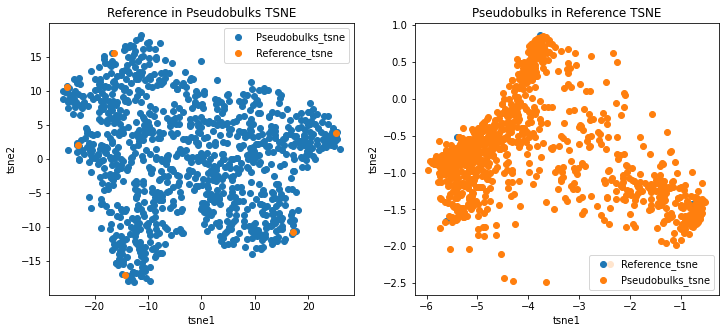

In [20]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [21]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df
all_refs_raw[0] = ref_raw
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df
#assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [22]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0


Exp 1


Exp 2


Exp 3


Exp 4


Evalutating NNLS Performance:

In [23]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

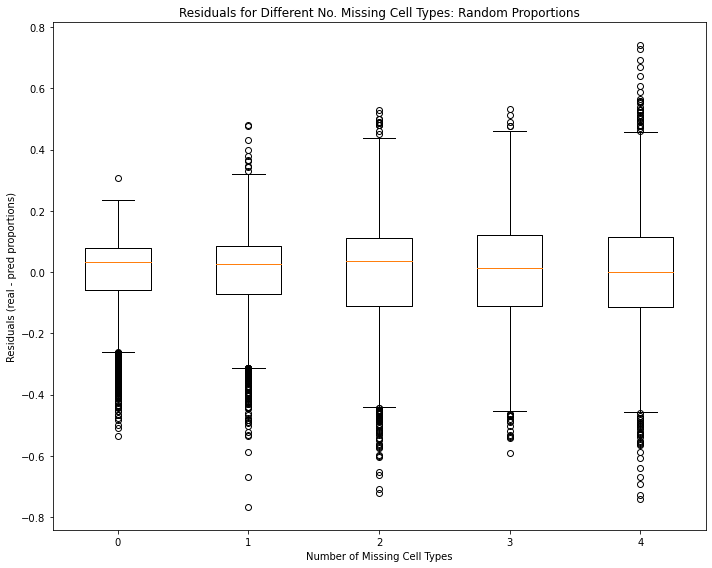

In [24]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

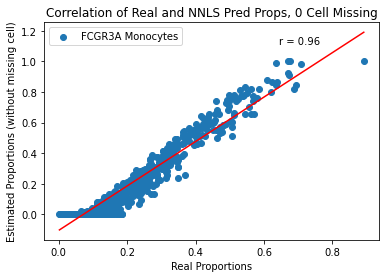

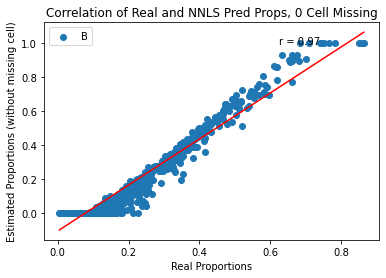

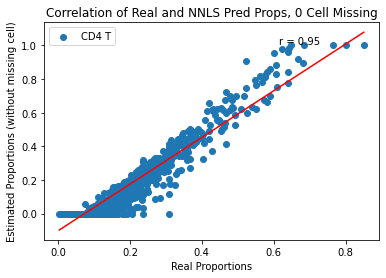

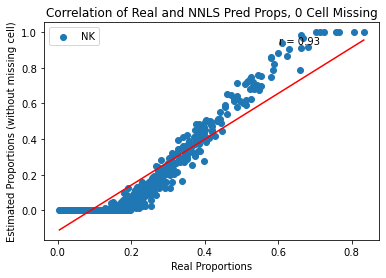

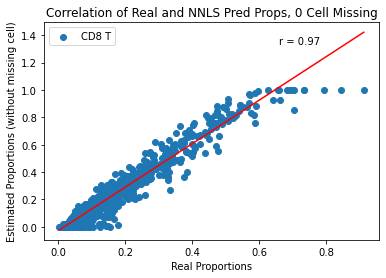

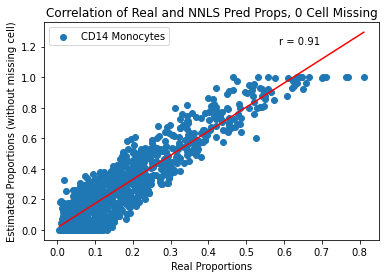

In [25]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


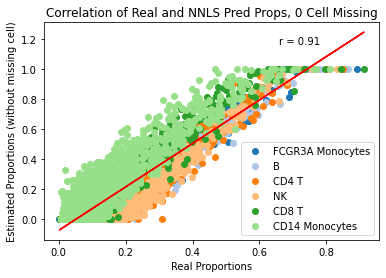

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


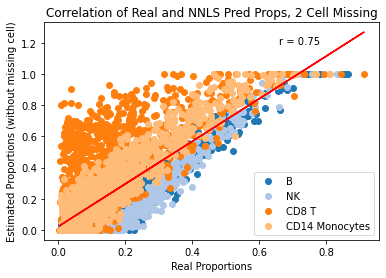

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


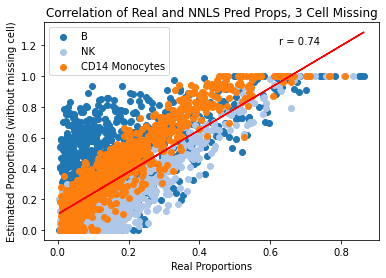

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


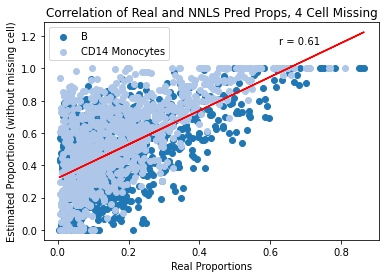

In [26]:
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Recreate Matrices:

In [27]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

HES4      SDF4    UBE2J2      MIB2      NADK      GNB1    KCNAB2  \
0    0.262066  0.398381  0.298697  0.223522  0.232956  0.427367  0.323745   
1    0.517991  0.375047  0.327913  0.191106  0.336001  0.580553  0.398904   
2    0.139795  0.366136  0.299170  0.177325  0.201809  0.469509  0.354387   
3    0.173183  0.443956  0.325119  0.274551  0.184962  0.396924  0.315506   
4    0.126436  0.396047  0.290098  0.197996  0.197957  0.436381  0.337005   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.120282  0.444842  0.304411  0.252746  0.202898  0.446807  0.342281   
996  0.213935  0.313291  0.255678  0.074651  0.258962  0.529924  0.384020   
997  0.199158  0.291833  0.247487  0.048329  0.255188  0.531089  0.385305   
998  0.035796  0.536829  0.382842  0.429194  0.121573  0.361529  0.299820   
999  0.027285  0.553086  0.389046  0.451102  0.115841  0.352452  0.295190   

     TNFRSF25     VAMP3      RBP7  ...    IFNAR2    IL10RB    IFNGR2  \
0    0.063170  0.271917  0.343488  ...  0.308110  0.412805  0.573935   
1    0.213910  0.377323  0.427678  ...  0.401812  0.551679  0.636618   
2    0.129397  0.306114  0.681537  ...  0.258966  0.371598  0.704478   
3    0.177239  0.241704  0.295873  ...  0.302456  0.350687  0.428843   
4    0.074688  0.290836  0.610303  ...  0.263150  0.366109  0.668241   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.065227  0.289063  0.584564  ...  0.287799  0.361301  0.619865   
996  0.031564  0.386542  0.940904  ...  0.256699  0.454759  0.953624   
997  0.024961  0.392209  1.000000  ...  0.240583  0.452753  1.000000   
998  0.246511  0.163720  0.129613  ...  0.308738  0.240717  0.192292   
999  0.251345  0.152537  0.084748  ...  0.313728  0.230768  0.151200   

         CBR1      TTC3       MX2    NDUFV3      PDXK      PFKL  AL592183.1  
0    0.472049  0.406434  0.375124  0.254838  0.261858  0.387491    0.367192  
1    0.632604  0.480040  0.693733  0.336024  0.358734  0.546714    0.346735  
2    0.531090  0.272539  0.510054  0.321465  0.336550  0.317366    0.290041  
3    0.431768  0.408183  0.399964  0.236818  0.225506  0.322946    0.345838  
4    0.507647  0.294415  0.392072  0.303039  0.311898  0.298314    0.305246  
..        ...       ...       ...       ...       ...       ...         ...  
995  0.515781  0.306496  0.386001  0.300570  0.303102  0.287070    0.303756  
996  0.645908  0.224219  0.496715  0.401319  0.440037  0.358204    0.265203  
997  0.651911  0.199158  0.501613  0.411328  0.454346  0.352377    0.257312  
998  0.337985  0.408503  0.439892  0.170757  0.134159  0.242452    0.348463  
999  0.323183  0.420040  0.428045  0.158766  0.117814  0.235494    0.353457  

[1000 rows x 1281 columns]

## **Extracting Missing Cell Information:**

In [28]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))



In [29]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

HES4      SDF4    UBE2J2      MIB2      NADK      GNB1    KCNAB2  \
0    0.153166 -0.009923 -0.037495  0.008406  0.004388 -0.190721  0.006875   
1    0.408674 -0.129397 -0.153968 -0.059955  0.074847 -0.185857  0.054475   
2   -0.024061 -0.028568 -0.019944 -0.063974 -0.111788 -0.180936 -0.143006   
3    0.058984 -0.145560  0.047224 -0.134022 -0.067542 -0.202536  0.071763   
4   -0.029698 -0.179122 -0.146404 -0.092523 -0.085383 -0.308082 -0.237129   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.024939 -0.091359 -0.140887 -0.064072 -0.031417 -0.270664 -0.127222   
996  0.010947 -0.172722 -0.137480 -0.008880 -0.100056 -0.257518 -0.251208   
997 -0.157192 -0.119604 -0.063574 -0.016546 -0.164879 -0.264001 -0.177445   
998  0.049961 -0.234891 -0.013927 -0.089883 -0.066556 -0.287211 -0.141955   
999 -0.009717 -0.385021 -0.220441 -0.278523 -0.077103 -0.294320 -0.215374   

     TNFRSF25     VAMP3      RBP7  ...    IFNAR2    IL10RB        IFNGR2  \
0   -0.019548  0.024831 -0.163030  ...  0.078133 -0.073654  1.379869e-01   
1   -0.030150 -0.026919 -0.323011  ...  0.034533 -0.086008  3.633819e-01   
2   -0.015092 -0.133077 -0.278803  ...  0.053821 -0.178625  2.948732e-01   
3   -0.003137 -0.016786 -0.228583  ...  0.073367 -0.155738  3.107104e-01   
4   -0.042620 -0.068368 -0.405989  ... -0.129375 -0.237485 -1.479018e-01   
..        ...       ...       ...  ...       ...       ...           ...   
995  0.011862 -0.057393 -0.449555  ...  0.178595 -0.216221  1.746147e-01   
996  0.001035 -0.012349 -0.474929  ... -0.010108 -0.112497  5.567226e-03   
997  0.023005 -0.195482 -0.345869  ... -0.147345 -0.264241  5.960464e-08   
998 -0.111812 -0.081518 -0.107939  ... -0.015123 -0.096108 -7.570044e-02   
999 -0.145496 -0.120932 -0.063834  ... -0.122081 -0.178485 -1.610157e-02   

         CBR1      TTC3       MX2    NDUFV3      PDXK      PFKL  AL592183.1  
0   -0.217100 -0.167252 -0.104676  0.085159 -0.077813 -0.234461    0.044336  
1   -0.334204 -0.255927 -0.127296 -0.074699 -0.159323 -0.128301   -0.028739  
2   -0.332669 -0.166972 -0.264504 -0.020640 -0.040700 -0.216048   -0.066170  
3   -0.209165 -0.216697 -0.176376 -0.049207 -0.103774 -0.181960   -0.159085  
4   -0.342842 -0.204423 -0.266104 -0.123004 -0.160197 -0.176423   -0.163102  
..        ...       ...       ...       ...       ...       ...         ...  
995 -0.289977 -0.232865 -0.187235  0.018369 -0.141206 -0.174935   -0.147364  
996 -0.305312 -0.134463 -0.183810 -0.053628 -0.176640 -0.197111   -0.046782  
997 -0.425183 -0.165471 -0.276653 -0.030434 -0.198163 -0.227592   -0.164452  
998 -0.268955 -0.343120 -0.238574 -0.118566 -0.088287 -0.169758   -0.083489  
999 -0.268486 -0.324195 -0.299284 -0.108430 -0.086525 -0.235494   -0.211560  

[1000 rows x 1281 columns]

## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [30]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [31]:
# SVD on pseudobulk for QC
df = normalized_pseudo_df
Mat_pseudo = df.astype("float32")
U_pseudo, s_pseudo, V_pseudo = sp.linalg.svd(Mat_pseudo)
U_pseudo = pd.DataFrame(U_pseudo)
s_pseudo = pd.DataFrame(s_pseudo)
V_pseudo = pd.DataFrame(V_pseudo)

In [32]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

In [33]:
#SVD on reference for QC
U_all_ref = dict()
s_all_ref = dict()
V_all_ref = dict()
Matref_all_ref = dict()

for num in num_cells_missing:
    df = all_refs[num]
    Mat_ref  = df.astype("float32")
    U_ref , s_ref , V_ref  = sp.linalg.svd(Mat_ref )
    U_ref = pd.DataFrame(U_ref )
    s_ref  = pd.DataFrame(s_ref )
    V_ref  = pd.DataFrame(V_ref )

    U_all_ref[num] = U_ref 
    s_all_ref[num] = s_ref 
    V_all_ref[num] = V_ref 
    Matref_all_ref[num] = Mat_ref 

In [34]:
#SVD on recreated matrix for QC
U_all_rec = dict()
s_all_rec = dict()
V_all_rec = dict()
Matres_all_rec = dict()

for num in num_cells_missing:
    df = recreated_mat_all[num]
    Mat_rec = df.astype("float32")
    U_rec , s_rec , V_rec  = sp.linalg.svd(Mat_rec )
    U_rec  = pd.DataFrame(U_rec )
    s_rec  = pd.DataFrame(s_rec )
    V_rec  = pd.DataFrame(V_rec )

    U_all_rec[num] = U_rec 
    s_all_rec[num] = s_rec 
    V_all_rec[num] = V_rec 
    Matres_all_rec[num] = Mat_rec 

S-Value Eval for each SVD:

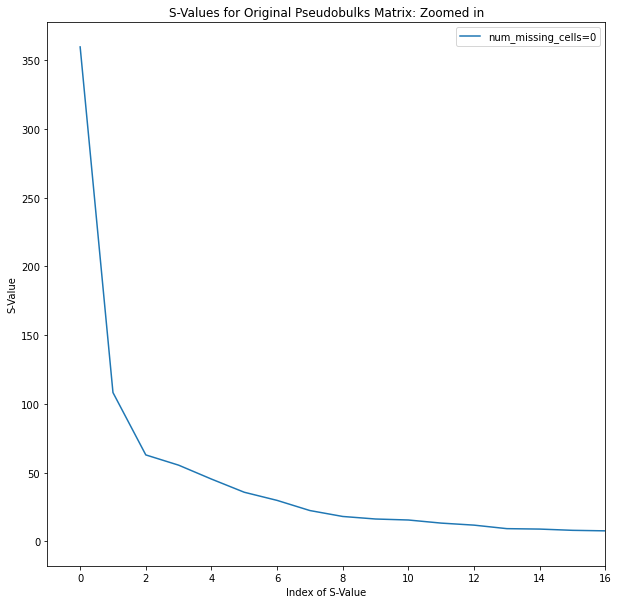

In [35]:
###SVD on Pseudobulk##
num =0
plt.figure(figsize = [10,10])
# Create a color map
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
dataframe = pd.DataFrame(s_pseudo)
x = dataframe.index
y = dataframe.values.flatten()
color = color_map(num_missing_cells.index(num))
label = f"num_missing_cells={num}"
plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Original Pseudobulks Matrix: Zoomed in')
plt.xlim([-1,num_celltypes + 10])
# Add a legend
plt.legend()
# Display the plot
plt.show()

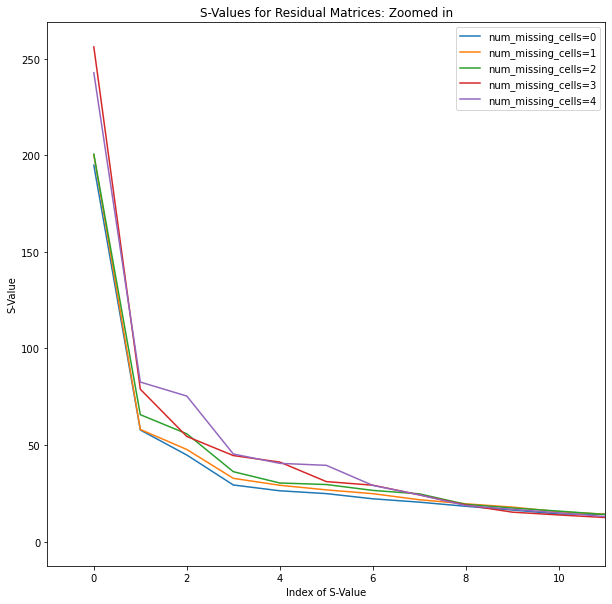

In [36]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

In [37]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_rec[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Recreated Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

In [38]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_ref[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Reference Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [39]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

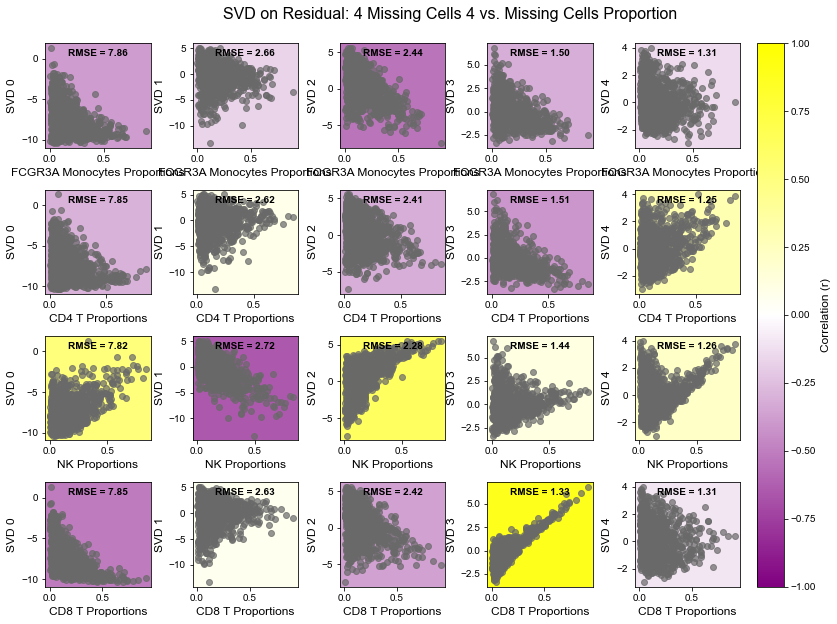

In [40]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

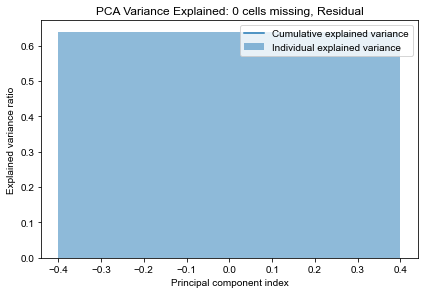

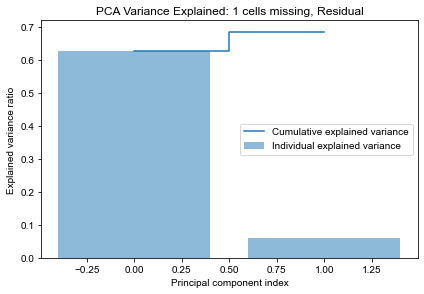

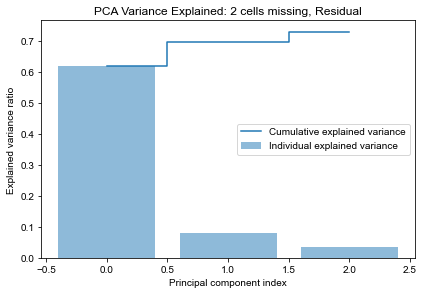

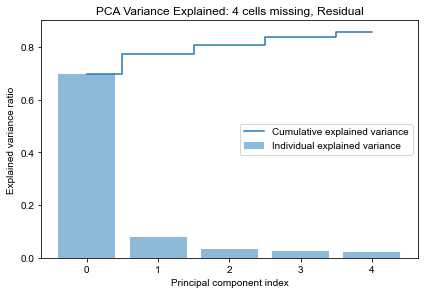

In [41]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

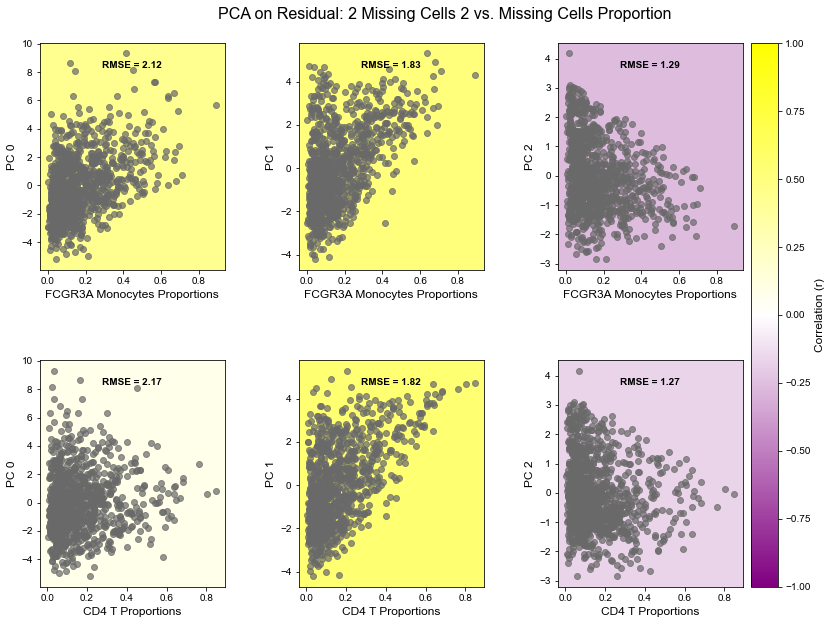

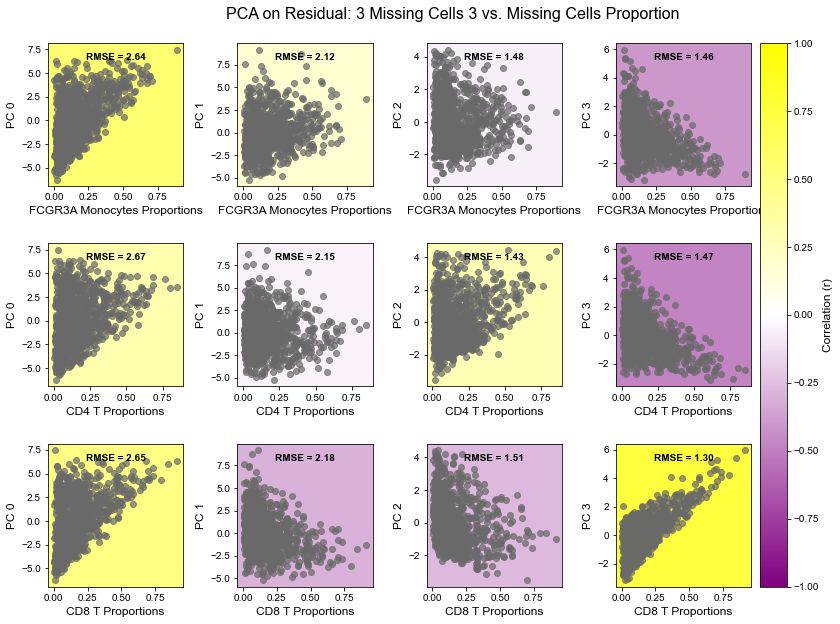

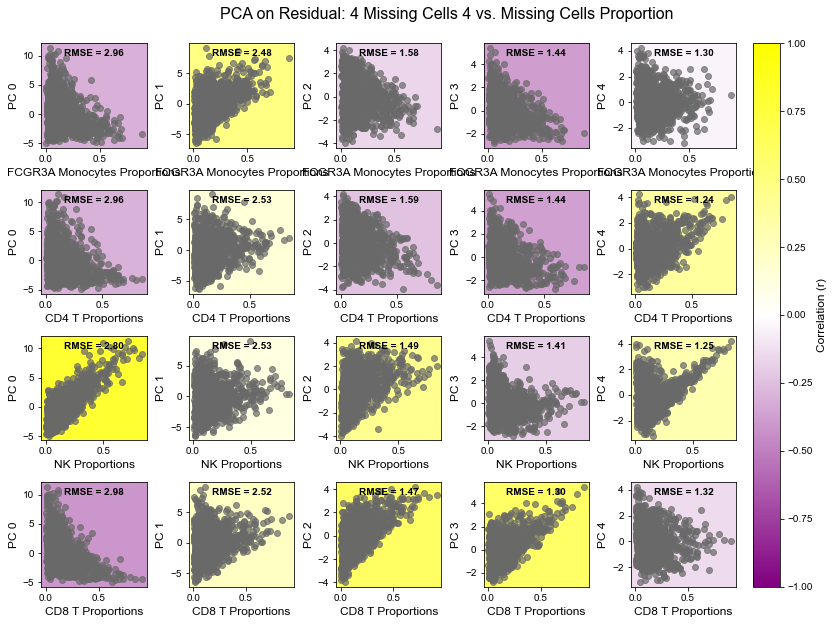

In [42]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [43]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

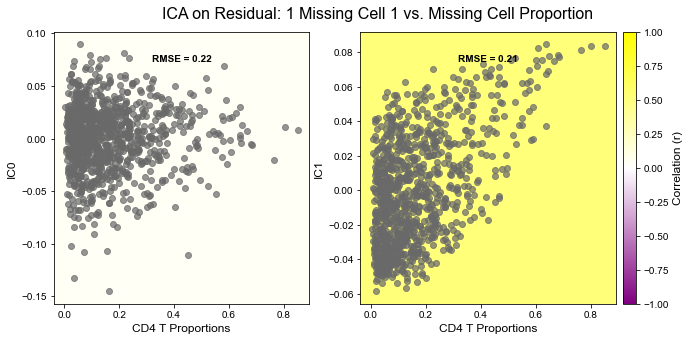

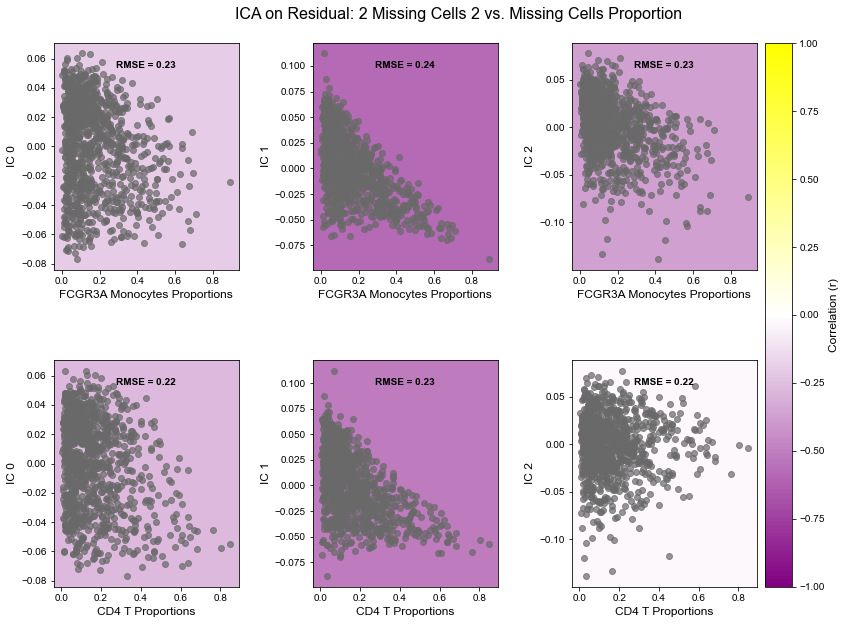

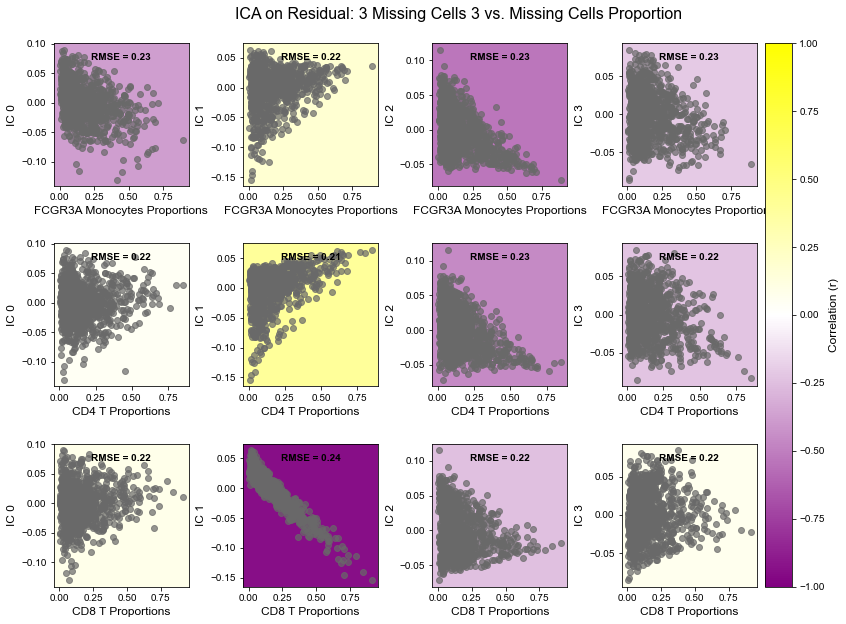

In [44]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

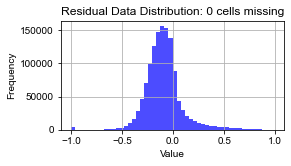

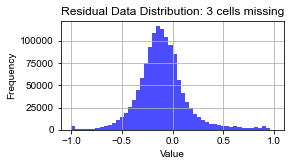

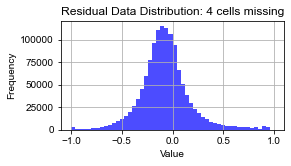

In [45]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9999999403953554


0.9999999403953554


0.9999999403953554


0.9999999403953554


0.9999999403953554


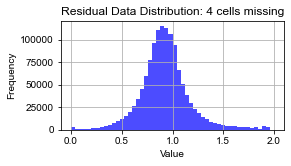

In [46]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Analyzing NMF Results:

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


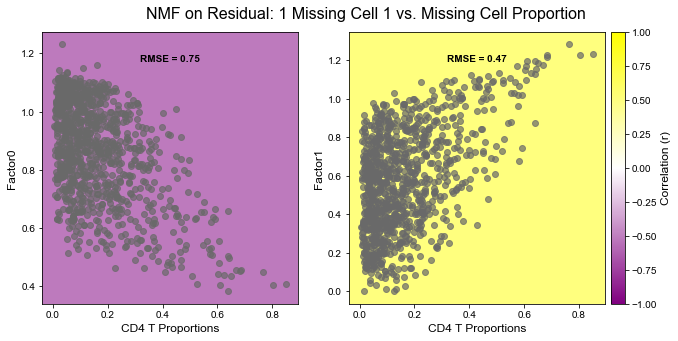

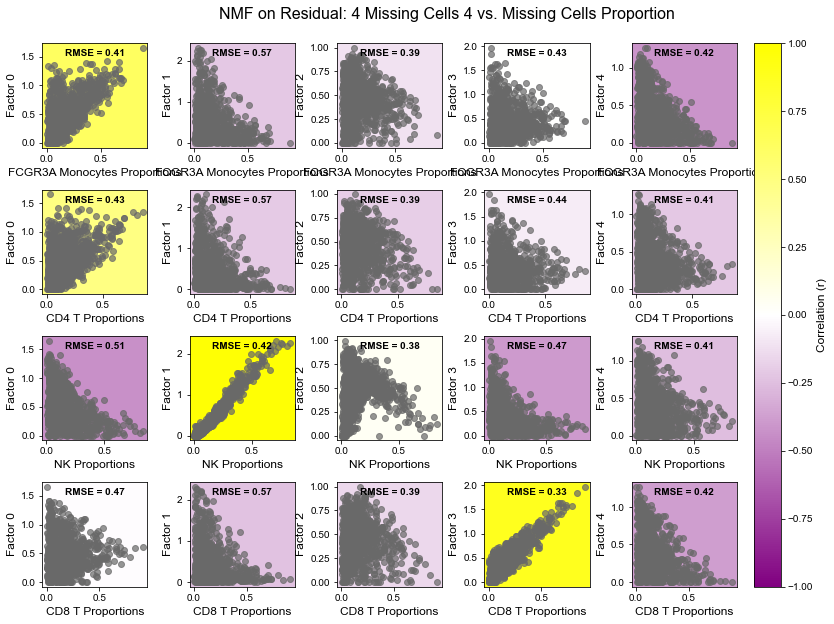

In [47]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


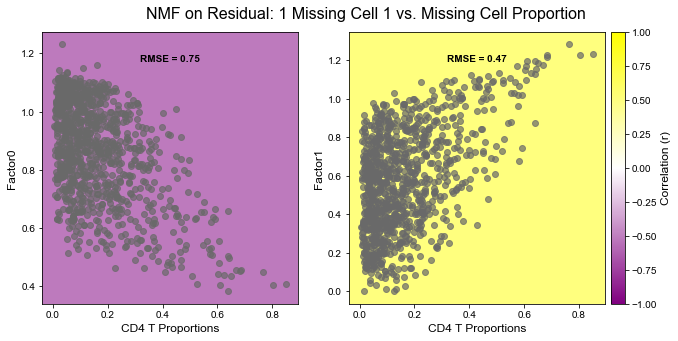

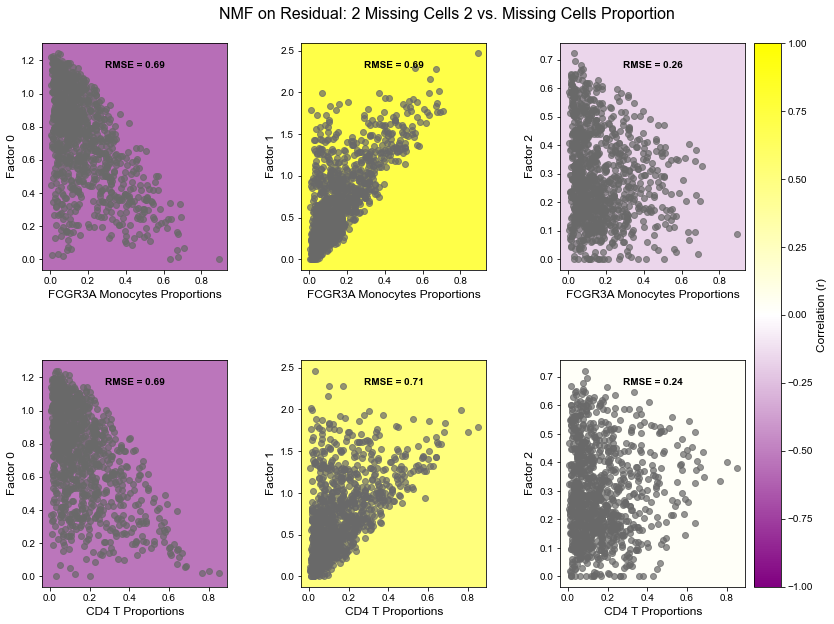

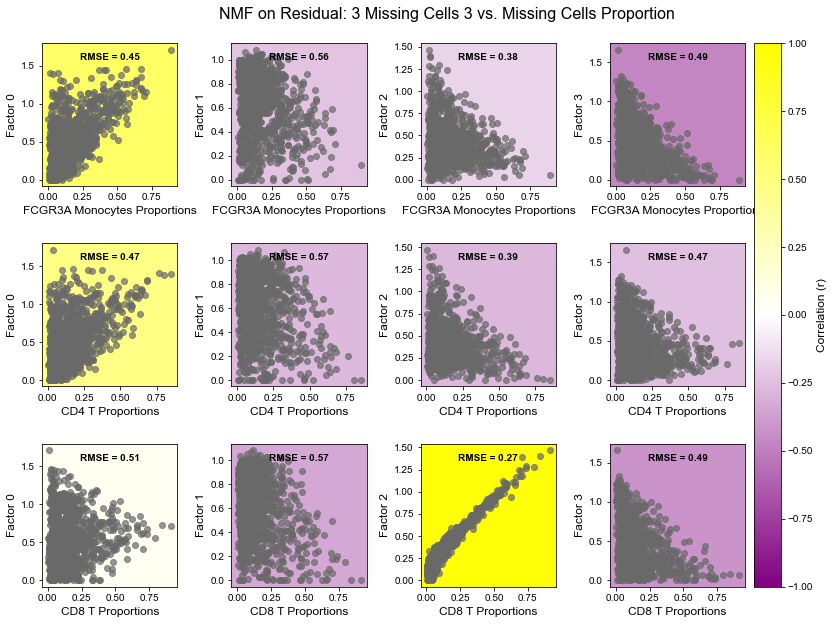

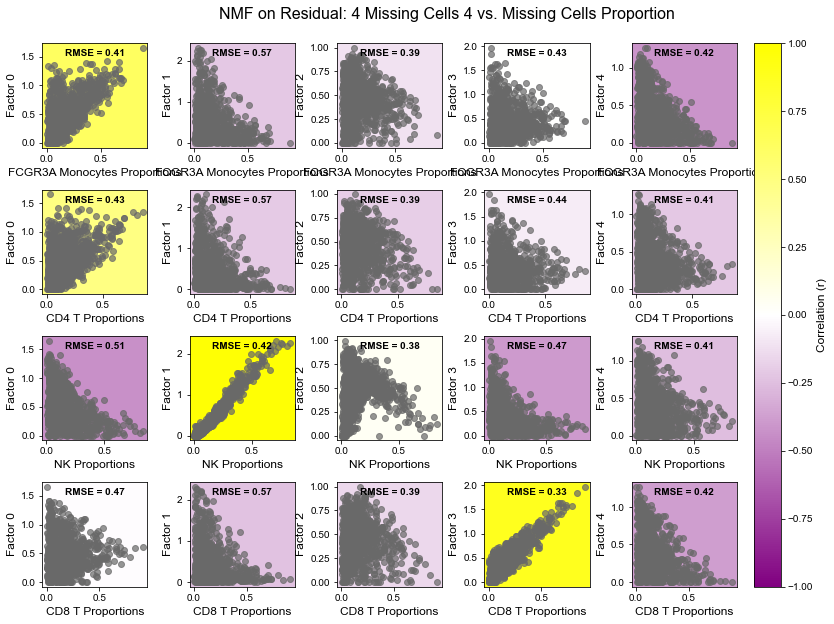

In [48]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 